In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"36,166,762","4,453,326","15,245,570","14,076,233"
Moderate,"6,482,890","128,624","2,116,742","1,714,583"
Heavy,"4,338,901","54,261","1,007,198","948,339"
Severe,"493,627","28,524","102,229","73,875"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,76.2%,95.5%,82.5%,83.7%
Moderate,13.7%,2.8%,11.5%,10.2%
Heavy,9.1%,1.2%,5.5%,5.6%
Severe,1.0%,0.6%,0.6%,0.4%


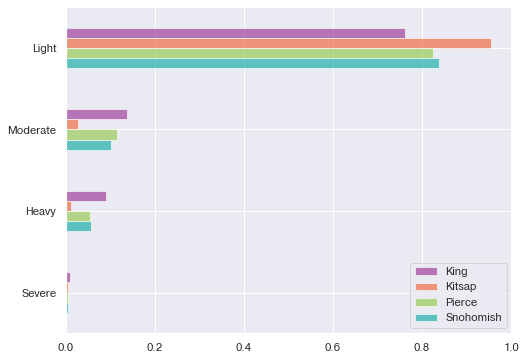

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

**Freeway** VMT by Congestion Category

In [12]:
# Segment by facility type
_df = df[df['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"17,709,966","1,940,904","6,113,540","6,748,629"
Moderate,"4,179,480","46,739","1,137,781","982,711"
Heavy,"2,910,749","14,665","593,764","559,187"
Severe,"216,745","20,738","49,035","28,205"


**Arterial** VMT by Congestion Category

In [13]:
# Segment by facility type
_df = df[df['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"16,062,619","2,127,749","7,959,714","6,157,708"
Moderate,"2,303,410","81,885","978,962","731,872"
Heavy,"1,428,152","39,596","413,433","389,152"
Severe,"276,883","7,786","53,195","45,670"


#### AM Peak (7 to 8 AM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,144,864","330,111","948,285","891,566"
Moderate,"625,750","17,063","236,167","189,720"
Heavy,"696,401","4,204","198,067","175,435"
Severe,"100,587","7,884","39,916","12,115"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,60.1%,91.9%,66.7%,70.3%
Moderate,17.5%,4.7%,16.6%,15.0%
Heavy,19.5%,1.2%,13.9%,13.8%
Severe,2.8%,2.2%,2.8%,1.0%


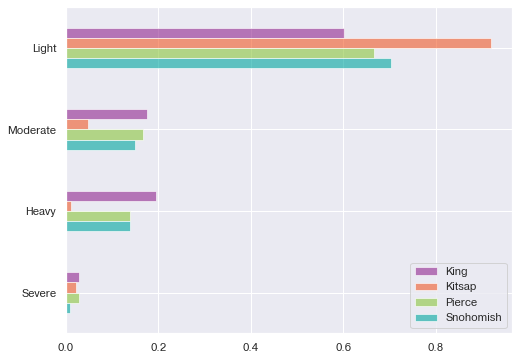

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

AM Peak **Freeway** VMT

In [18]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"888,204","148,812","298,867","392,065"
Moderate,"381,927","8,554","138,531","117,391"
Heavy,"504,589",463,"141,871","127,001"
Severe,"62,352","7,095","33,321","6,662"


AM Peak **Arterial** VMT

In [19]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,109,499","158,049","575,250","428,169"
Moderate,"243,823","8,509","97,636","72,329"
Heavy,"191,812","3,742","56,196","48,435"
Severe,"38,235",789,"6,595","5,454"


#### PM Peak (5 to 6 PM)

In [25]:
pd.options.display.float_format = '{:0,.0f}'.format
df_pm = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,422,855","378,119","1,084,117","1,001,400"
Moderate,"770,548","14,135","268,709","216,930"
Heavy,"688,004","4,446","193,164","175,393"
Severe,"108,345","7,695","13,687","16,706"


In [26]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,60.7%,93.5%,69.5%,71.0%
Moderate,19.3%,3.5%,17.2%,15.4%
Heavy,17.2%,1.1%,12.4%,12.4%
Severe,2.7%,1.9%,0.9%,1.2%


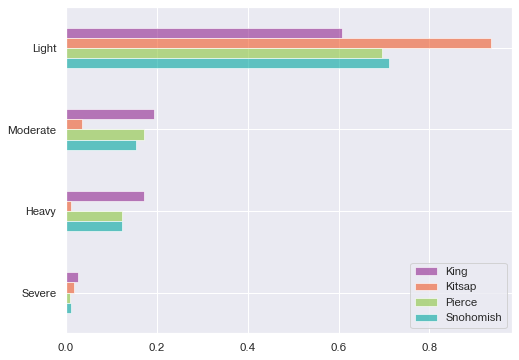

In [27]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM **Freeway** VMT

In [28]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"910,970","160,572","329,972","415,410"
Moderate,"476,789","6,222","157,196","130,390"
Heavy,"487,929",359,"131,607","114,616"
Severe,"65,524","6,482","5,222","7,898"


PM **Arterial** VMT

In [29]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,310,522","185,514","657,057","489,449"
Moderate,"293,759","7,913","111,513","86,540"
Heavy,"200,075","4,087","61,557","60,777"
Severe,"42,821","1,213","8,466","8,807"


# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [14]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"4,650,722","390,395","1,602,587","1,691,247"
Moderate,"829,469","7,925","244,268","189,120"
Heavy,"541,654","2,970","105,503","85,112"
Severe,"42,294","1,801","9,873","4,738"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,76.7%,96.9%,81.7%,85.8%
Moderate,13.7%,2.0%,12.4%,9.6%
Heavy,8.9%,0.7%,5.4%,4.3%
Severe,0.7%,0.4%,0.5%,0.2%


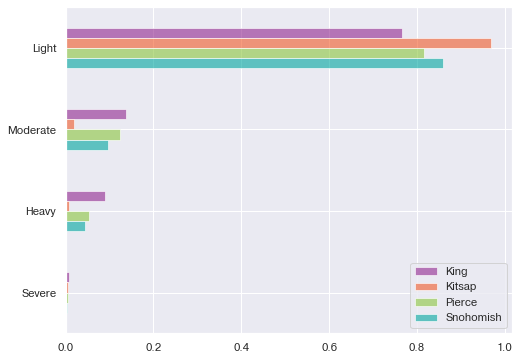

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,270,067","151,831","891,361","966,653"
Moderate,"386,423","2,433","145,969","98,041"
Heavy,"250,244",756,"67,058","42,002"
Severe,"15,442",718,"6,609","1,672"


In [19]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,77.7%,97.5%,80.2%,87.2%
Moderate,13.2%,1.6%,13.1%,8.8%
Heavy,8.6%,0.5%,6.0%,3.8%
Severe,0.5%,0.5%,0.6%,0.2%


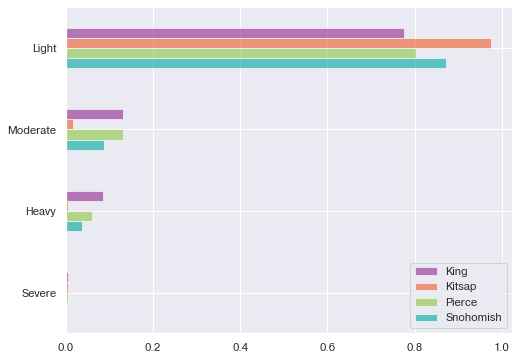

In [20]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"26,852","1,083","3,264","3,066"
Heavy,"291,411","2,214","38,445","43,111"
Moderate,"443,046","5,492","98,299","91,079"
Light,"2,380,655","238,565","711,226","724,594"


In [22]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,380,655","238,565","711,226","724,594"
Moderate,"443,046","5,492","98,299","91,079"
Heavy,"291,411","2,214","38,445","43,111"
Severe,"26,852","1,083","3,264","3,066"


In [23]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,75.8%,96.4%,83.6%,84.1%
Moderate,14.1%,2.2%,11.5%,10.6%
Heavy,9.3%,0.9%,4.5%,5.0%
Severe,0.9%,0.4%,0.4%,0.4%


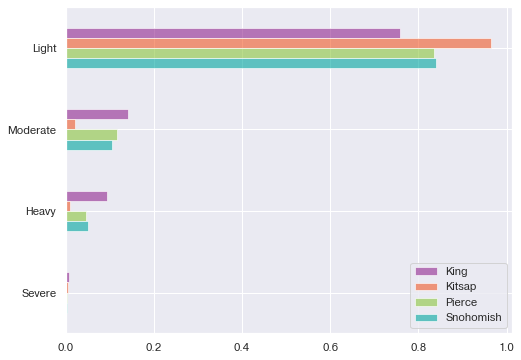

In [24]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');